In [2]:
# Install kaggle
!pip install kaggle


In [14]:
# Importing kaggle and downloading the dataset
import kaggle

!kaggle datasets download -d vivek468/superstore-dataset-final -p ./data/

Dataset URL: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final
License(s): other
  0%|                                                | 0.00/550k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 550k/550k [00:00<00:00, 646MB/s]


In [18]:
# Unzipping the file
!unzip ./data/superstore-dataset-final.zip -d ./data/

Archive:  ./data/superstore-dataset-final.zip
  inflating: ./data/Sample - Superstore.csv  


In [3]:
# Import pandas

import pandas as pd

# reading the csv, setting invalid values to na
df = pd.read_csv('./data/superstore.csv', encoding="ISO-8859-1", na_values=["", " ", "NA", "N/A", "na", "NaN", "Unknown", "?"])



In [4]:
# Structuring the data field names

df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

# print(df.columns)

In [16]:
# Installing dotenv and sqlalchemy, and pgsql binary
!pip install psycopg2-binary sqlalchemy python-dotenv



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [265]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd

# Load environment variables
load_dotenv()

# Get the connection string from .env
conn_str = os.getenv("NEON_DB_URL")

# Create SQLAlchemy engine
engine = create_engine(conn_str)

conn=engine.connect()


In [20]:
# Dumping data to pgsql of neondb (Cloud based)

df.to_sql("superstore", engine, index=False, if_exists="replace")

994

In [25]:
# Performing operations using Python + SQL

In [ ]:
# 1. Extracting Business Metrics (Total Sales, Total Profit, Profit Margin

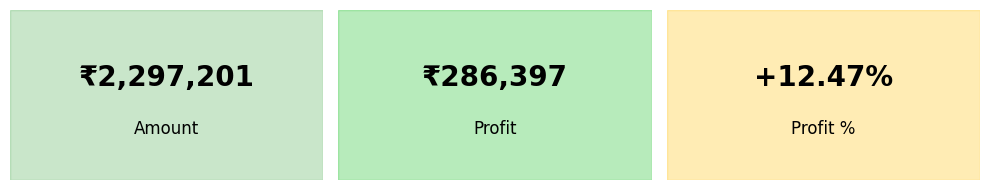

In [247]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import pandas as pd

# SQL query
query = """
SELECT SUM(sales)::int AS total_sales, SUM(profit)::int AS total_profit FROM superstore
"""
metrics = pd.read_sql(query, engine)

total_sales = metrics['total_sales'].iloc[0]
total_profit = metrics['total_profit'].iloc[0]
profit_percent = math.ceil((total_profit * 100 / total_sales) * 100) / 100

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 2))

# Define the cards' data
cards = [
    {"value": f"₹{total_sales:,}", "label": "Amount", "color": "#4CAF50"},
    {"value": f"₹{total_profit:,}", "label": "Profit", "color": "#13BF1E"},
    {"value": f"+{profit_percent}%", "label": "Profit %", "color": "#FFC107"}
]

# Plot each card
for ax, card in zip(axes, cards):
    ax.add_patch(Rectangle((0,0),1,1,color=card["color"], alpha=0.3))
    ax.text(0.5, 0.6, card["value"], fontsize=20, ha='center', va='center', weight='bold', color='black')
    ax.text(0.5, 0.3, card["label"], fontsize=12, ha='center', va='center', color='black')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.axis('off')

plt.tight_layout()
plt.show()


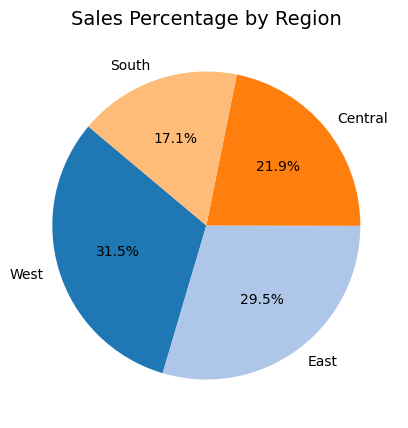

In [220]:
# Percentage break-up of sales by Region

query = """
 SELECT region, SUM(sales) AS sales FROM superstore
 GROUP BY region
 ORDER BY SUM(sales) DESC
"""

sales_by_region = pd.read_sql(query, engine)
sales_by_region['sales'] = np.ceil((sales_by_region['sales'] * 100 / total_sales) * 10)/10

plt.figure(figsize=(5,5))
plt.pie(
    sales_by_region['sales'], 
    labels=sales_by_region['region'], 
    autopct='%1.1f%%',      # shows percentages on pie slices
    startangle=140,         # rotate so the first slice starts nicely
    colors=plt.cm.tab20.colors  # optional: use a colormap for colors
)

plt.title("Percentage break-up of sales by Region", fontsize=14)
plt.show()

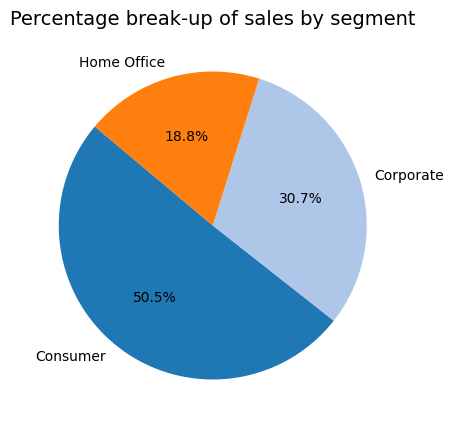

In [237]:
# Percentage break-up of sales by Customer-segment

query = """
 SELECT segment, SUM(sales) AS sales FROM superstore
 GROUP BY segment
 ORDER BY SUM(sales) DESC
"""

sales_by_segment = pd.read_sql(query, engine)
sales_by_segment['sales'] = np.ceil((sales_by_segment['sales'] * 100 / total_sales) * 10)/10

plt.figure(figsize=(5,5))
plt.pie(
    sales_by_segment['sales'], 
    labels=sales_by_region['segment'], 
    autopct='%1.1f%%',      # shows percentages on pie slices
    startangle=140,         # rotate so the first slice starts nicely
    colors=plt.cm.tab20.colors  # optional: use a colormap for colors
)

plt.title("Percentage break-up of sales by segment", fontsize=14)
plt.show()

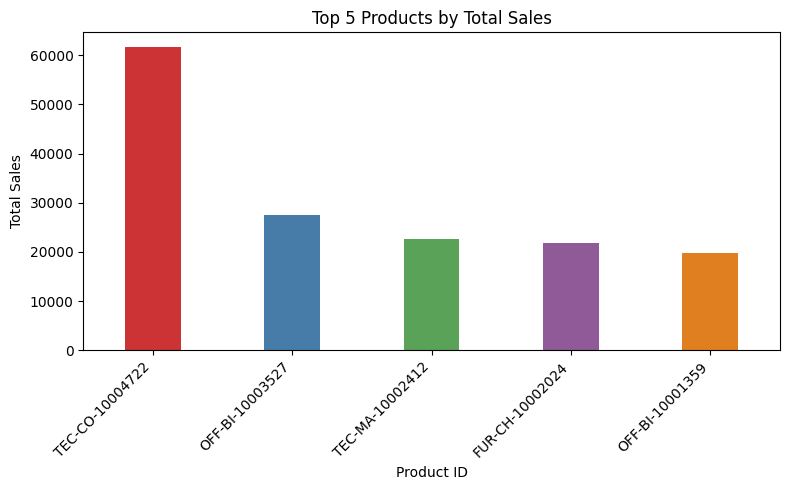

In [233]:
# Querying the top 5 products in terms of generating revenue

query = """
SELECT product_id, product_name, SUM(sales) as total_sales 
FROM superstore
GROUP BY product_id, product_name
ORDER BY SUM(sales) DESC
LIMIT 5
"""

top_10_products = pd.read_sql(query, engine)

# Plotting the data for the top 5 products
plt.figure(figsize=(8,5))
sns.barplot(
    data=top_10_products,
    x='product_id',
    y='total_sales',
    hue='product_id', 
    palette='Set1',
    legend=False,
    width= 0.4
)
plt.title('Top 5 Products by Total Sales')
plt.xlabel('Product ID')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

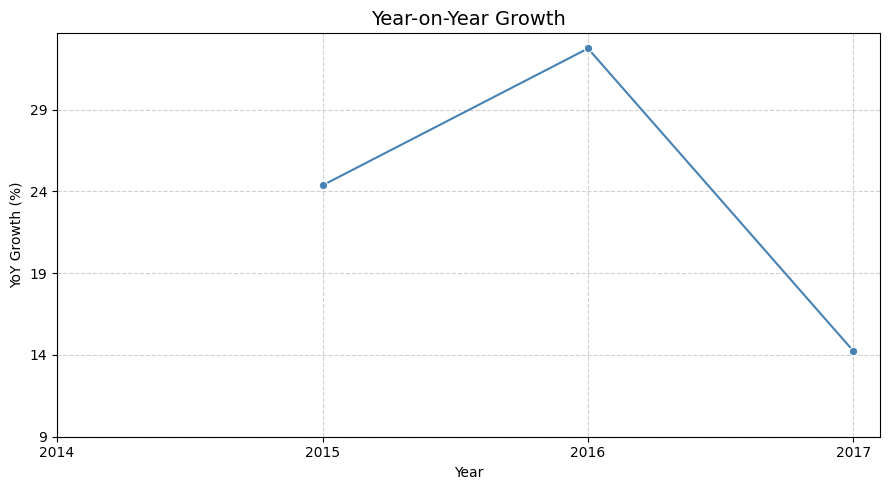

In [239]:
# Year On Year Profit Growth 

query = """
WITH base AS (SELECT EXTRACT(YEAR FROM order_date::date) AS year, SUM(profit) 
FROM superstore
GROUP BY EXTRACT(YEAR FROM order_date::date))
SELECT year1 AS year, (CASE WHEN sum2 IS NOT NULL THEN (sum1-sum2)*100.0/sum2 ELSE NULL END) AS yoy_growth FROM
(SELECT b1.year AS year1, b1.sum AS sum1, b2.year AS year2, b2.sum AS sum2 FROM base b1
LEFT JOIN base b2 ON b1.year = b2.year + 1) AS T
"""

yoy_growth = pd.read_sql(query, engine)

plt.figure(figsize=(9,5))
sns.lineplot(
    data=yoy_growth,
    x='year',
    y='yoy_growth',
    marker='o',
    color='steelblue'
)

plt.title("Year-on-Year Growth", fontsize=14)
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")

plt.xticks(sorted(yoy_growth['year'].unique()))

ymin, ymax = plt.ylim()
plt.yticks(np.arange(9, round(ymax) + 5, 5))
plt.ylim(9, ymax)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

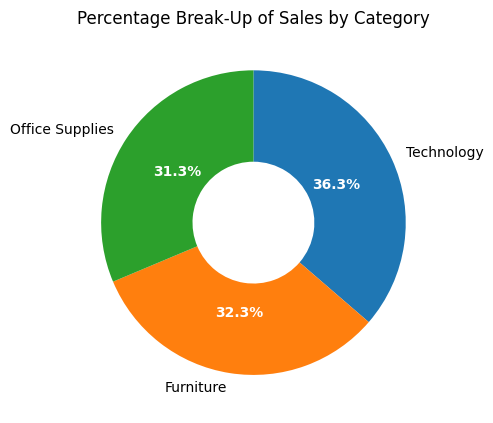

In [263]:
# Percentage Break-Up Sales By Category

query = """
    SELECT category, SUM(sales) AS sales 
    FROM superstore
    GROUP BY category
    ORDER BY COUNT(category)
"""

# Read data from database
sales_by_cat = pd.read_sql(query, engine)

# Calculate total sales
total_sales = sales_by_cat['sales'].sum()

# Convert to percentage (rounded to 1 decimal place)
sales_by_cat['sales_pct'] = np.ceil((sales_by_cat['sales'] * 100.0 / total_sales) * 10) / 10

# --- Ring (Donut) Plot ---
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    sales_by_cat['sales_pct'],
    labels=sales_by_cat['category'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.6)  # <- makes the pie a ring
)

# Center circle for the donut hole
plt.setp(autotexts, size=10, weight="bold", color="white")
plt.title('Percentage Break-Up of Sales by Category', fontsize=12)
plt.tight_layout()
plt.show()

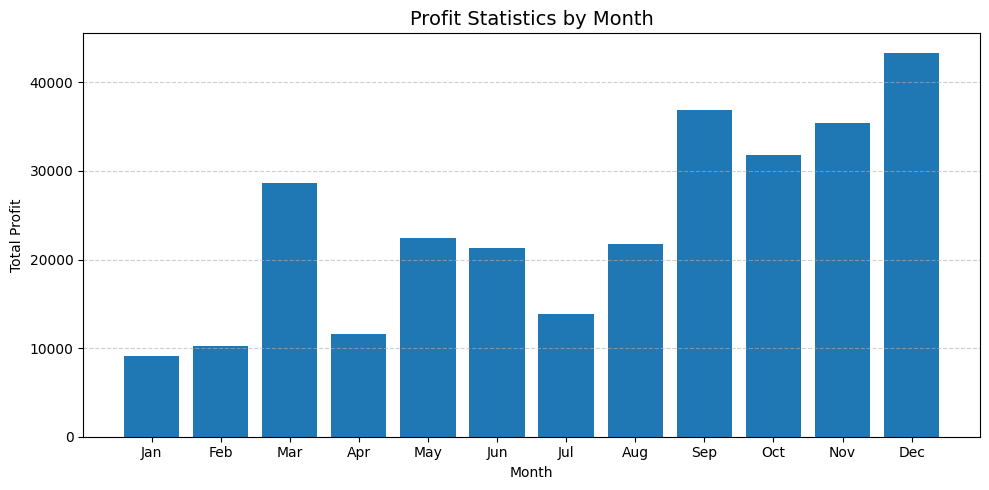

In [272]:
# Profit Statistics By Month


query = """
    SELECT 
        EXTRACT(MONTH FROM order_date::date) AS month,
        SUM(profit) AS profit
    FROM superstore
    GROUP BY EXTRACT(MONTH FROM order_date::date)
    ORDER BY month
"""

# Read data
profit_by_months = pd.read_sql(query, engine)

# Optional: map month numbers to names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
profit_by_months['month'] = profit_by_months['month'].astype(int)
profit_by_months['month_name'] = profit_by_months['month'].apply(lambda x: month_names[x-1])

# --- Bar Plot ---
plt.figure(figsize=(10, 5))
plt.bar(profit_by_months['month_name'], profit_by_months['profit'])

plt.title('Profit Statistics by Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()